> Solve Kuramoto–Sivashinsky with PIML

<center>$\large \frac{\partial u}{\partial t}=-v\frac{\partial^4 u}{\partial x^4}-\frac{\partial^2 u}{\partial x^2}-u\frac{\partial u}{\partial x}$</center>

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px
import progressbar
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

In [2]:
data = pd.read_parquet('Data/KS_data.parquet')

Scaling the data or PCA won't work

In [3]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data))
data = data.applymap(lambda n: (n + 1) / 2) # set all values bewteen 0 and 1

In [4]:
data.loc[:10, :10]  # just an example

,0,1,2,3,4,5,6,7,8,9,10
0,-0.478193,-0.423484,-0.361481,-0.294564,-0.224610,-0.153012,-0.080711,-0.008241,0.064236,0.136886,0.210136
1,-0.422947,-0.359123,-0.291522,-0.221948,-0.151654,-0.081407,-0.011565,0.057864,0.127159,0.196825,0.267534
2,-0.355469,-0.286757,-0.217152,-0.147817,-0.079377,-0.012018,0.054417,0.120348,0.186393,0.253301,0.321885
3,-0.280954,-0.210939,-0.142184,-0.075218,-0.010091,0.053510,0.116160,0.178607,0.241705,0.306349,0.373406
4,-0.204034,-0.135486,-0.069613,-0.006376,0.054664,0.114221,0.173183,0.232528,0.293251,0.356305,0.422529
5,-0.128438,-0.063269,-0.001522,0.057319,0.114079,0.169773,0.225505,0.282389,0.341478,0.403704,0.469814
6,-0.056850,0.003817,0.060877,0.115222,0.167962,0.220317,0.273522,0.328744,0.387020,0.449199,0.515869
7,0.009049,0.064755,0.117113,0.167289,0.216590,0.266360,0.317883,0.372313,0.430609,0.493473,0.561285
8,0.068433,0.119234,0.167275,0.213910,0.260565,0.308631,0.359380,0.413892,0.472988,0.537174,0.606572
9,0.121133,0.167462,0.211848,0.255763,0.300679,0.347975,0.398855,0.454267,0.514849,0.580858,0.652112


In [ ]:
go.Figure(data =
    go.Contour(
        z=data.loc[:1000].to_numpy()
    )).write_image('images/problem_3_data_example.png')

![](images/problem_3_data_example.png)

In [ ]:
def test_n_components_acc(n, data):
    pca = PCA(n_components=n)
    reduced_data = pca.fit_transform(data)
    aux = pca.inverse_transform(reduced_data)
    return mean_absolute_error(data, aux)

In [ ]:
pca_n_acc = []
for i in progressbar.progressbar(range(2, 50)):
    pca_n_acc.append(test_n_components_acc(i, data))

# I started with n_components up to 50 above, but results were bad even for 50, I just extended the test
# in order to save time, that's why the X of the chart looks like that

for i in progressbar.progressbar(range(50, 200, 10)):
    pca_n_acc.append(test_n_components_acc(i, data))

In [ ]:
px.line(x=[*range(2, 50), *range(50, 200, 10)], y=pca_n_acc,
        title='Reduced data difference to real').write_image('images/PCA_components_test.png')

![](images/PCA_components_test.png)

I'll use 90 as the number of components, that's the first one where the difference to original on return is negligible

In [5]:
pca = PCA(n_components=90)

In [6]:
%%time
reduced_data = pca.fit_transform(data)

CPU times: total: 57.6 s
Wall time: 5.59 s


In [7]:
mean_absolute_error(data, pca.inverse_transform(reduced_data))

0.0006817917827186932

In [8]:
reduced_data = pd.DataFrame(reduced_data)

scale the reduced data

In [9]:
red_scaler = StandardScaler()
reduced_data = pd.DataFrame(red_scaler.fit_transform(reduced_data))
reduced_data = reduced_data.applymap(lambda n: (n + 1) / 2) # set all values bewteen 0 and 1

---

### LSTM

I want to try a LSTM, gonna start with a relatively tame one

reshape data

In [ ]:
sample_size = 1000
X, y = [], []
for i in range(len(reduced_data) - (sample_size + 1)):
    X.append(reduced_data.loc[i:i + sample_size - 1].to_numpy())
    y.append(reduced_data.loc[i + sample_size].to_numpy())

In [ ]:
len(X), len(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(128, input_shape=(1000, 90)))
model.add(layers.Dense(90))
model.compile()
model.summary()

In [ ]:
model.fit(
    X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=1
)

So the model is eating my whole vram even with batch_size = 1, there's no way I'm running this. Will change my approach to DeepONets

---

### DeepONets

In [ ]:
import deepxde as dde

In [ ]:
data = dde.data.TripleCartesianProd(X_train, np.array(y_train), X_test, y_test)

I have no idea what shape is the input expected to be in, [the docs are vague](https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html#deepxde.data.triple.TripleCartesianProd) and [the examples are no better](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html#complete-code)

---

### OpInf

[Willcox-Research-Group OpInf looks good and has docs, gonna try it](https://willcox-research-group.github.io/rom-operator-inference-Python3/content/index.html)

In [10]:
import opinf
import scipy.linalg as la
import matplotlib.pyplot as plt

In [11]:
Q = data.T
dt = 0.25
q0 = Q[0].to_numpy()
t = []
start = 0
for i in range(len(Q.columns)):
    t.append(start)
    start += dt

t = np.array(t)

In [12]:
basis = opinf.pre.PODBasis().fit(Q.to_numpy(), r=90)                # Construct the low-dimensional basis.
basis

PODBasis
Full-order dimension    n = 512
Reduced-order dimension r = 90

In [13]:
Qdot = opinf.pre.ddt(Q, dt)                    # Calculate the time derivative matrix.
Qdot.shape

(512, 200000)

In [28]:
rom = opinf.ContinuousOpInfROM(modelform='A')           # Define the model structure.
rom.fit(basis, Q, Qdot, regularizer=1e-2)               # Construct the ROM with OpInf.

Reduced-order model structure: dq / dt = Aq(t)
Full-order dimension    n = 512
Reduced-order dimension r = 90

In [30]:
%%time
Q_ROM = rom.predict(q0, t, method='BDF', max_step=dt)   # Simulate the ROM.

CPU times: total: 52.4 s
Wall time: 50.2 s


In [31]:
opinf.post.frobenius_error(Q, Q_ROM)[1]                 # Calculate the relative error of the ROM simulation.

1.3868865870980476

doesnt look good

In [32]:
svdvals = la.svdvals(Q)

In [33]:
kappa = .999999
r = opinf.pre.cumulative_energy(svdvals, kappa, plot=False)
print(f"r = {r:d} singular values exceed {kappa:.4%} energy")

r = 95 singular values exceed 99.9999% energy


In [34]:
r = 90
Vr, _ = opinf.pre.pod_basis(Q, r, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (512, 90)


In [35]:
x_all = np.array(data.columns)

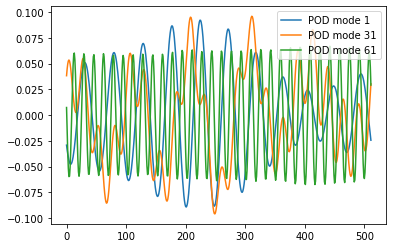

In [36]:
for j in range(0, Vr.shape[1], 30):
    plt.plot(x_all, Vr[:, j], label=f'POD mode {j+1}')

plt.legend(loc="upper right")
plt.show()

In [37]:
Q = Q.to_numpy()

In [38]:
Qdot2 = opinf.pre.ddt_uniform(Q, dt, order=6)

# Check that the estimate is close to the true time derivatives.
la.norm(Qdot - Qdot2, ord=np.inf) / la.norm(Qdot, ord=np.inf)

0.003850716035645095

In [39]:
Q_ = Vr.T @ Q                                   # Project the state snapshots.
Qdot_ = opinf.pre.ddt_uniform(Q_, dt, order=6)  # Estimate the projected time derivatives.

np.allclose(Vr.T @ Qdot2, Qdot_)                # Same as project the full-order time derivatives.

False

In [40]:
rom = opinf.ContinuousOpInfROM('A')
rom

Reduced-order model structure: dq / dt = Aq(t)

In [42]:
rom.fit(Vr, Q, Qdot, regularizer=1e-2)

Reduced-order model structure: dq / dt = Aq(t)
Full-order dimension    n = 512
Reduced-order dimension r = 90

In [43]:
Q_ROM = rom.predict(q0, t, method='BDF', max_step=dt)
Q_ROM.shape

(512, 200000)

In [44]:
fig = go.Figure(data =
    go.Contour(
        z=Q[:, :1000]
    ))
fig.update_layout(title='Original Q first 1000 steps')
fig.write_image('images/problem_3_q_first_1000_2.png')

![](images/problem_3_q_first_1000_2.png)

In [45]:
fig = go.Figure(data =
    go.Contour(
        z=Q_ROM[:, :1000]
    ))
fig.update_layout(title='Q ROM first 1000 steps')
fig.write_image('images/problem_3_qrom_first_1000_2.png')

![](images/problem_3_qrom_first_1000_2.png)

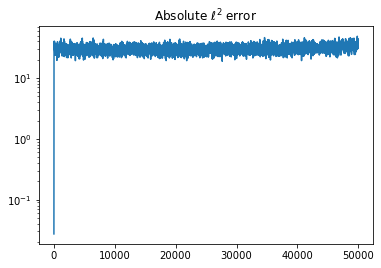

In [46]:
abs_l2err, rel_l2err = opinf.post.lp_error(Q, Q_ROM)
plt.semilogy(t, abs_l2err)
plt.title(r"Absolute $\ell^{2}$ error")
plt.show()

In [47]:
abs_froerr, rel_froerr = opinf.post.frobenius_error(Q, Q_ROM)
print(f"Relative Frobenius-norm error: {rel_froerr:%}")

Relative Frobenius-norm error: 138.688659%


In [62]:
# Get a new, slightly larger POD basis
r = 150
Vr, svdvals = opinf.pre.pod_basis(Q, r, mode="dense")

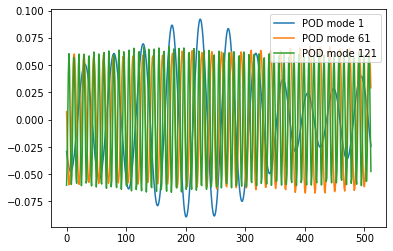

In [68]:
for j in range(0, Vr.shape[1], 60):
    plt.plot(x_all, Vr[:, j], label=f'POD mode {j+1}')

plt.legend(loc="upper right")
plt.show()

In [70]:
# Learn a new ROM using the new basis
# (but only using snapshot data from one initial condition).
rom_new = opinf.ContinuousOpInfROM("A").fit(Vr, Q, Qdot)

In [72]:
%%time
Q_ROM = rom.predict(q0, t, method='BDF', max_step=dt)
Q_ROM.shape

CPU times: total: 52.7 s
Wall time: 50.5 s


(512, 200000)

In [74]:
abs_froerr, rel_froerr = opinf.post.frobenius_error(Q, Q_ROM)
print(f"Relative Frobenius-norm error: {rel_froerr:%}")

Relative Frobenius-norm error: 138.688659%


In [73]:
fig = go.Figure(data =
    go.Contour(
        z=Q_ROM[:, :1000]
    ))
fig.update_layout(title='New Q ROM first 1000 steps')
fig.write_image('images/problem_3_new_qrom_first_1000.png')

![](images/problem_3_new_qrom_first_1000.png)

This is still very far, by the tests I've made with PCA before, 150 should be more than enough dimensions to represent the data

I'll try a hyperparameter optimization with optuna

In [14]:
import optuna

In [15]:
Q.shape

(512, 200000)

In [16]:
Qdot.shape

(512, 200000)

In [17]:
q0.shape

(512,)

In [18]:
t.shape

(200000,)

In [19]:
dt

0.25

In [27]:
def train_rom(r: int, mode: str, model_form: str, method: str) -> float:
    """
    Train a rom for parameters and return Relative Frobenius-norm error
    
    Arguments:
        - r {int} -- number of POD basis
        - mode {str} -- POD mode (should be one of 'dense', 'sparse', 'randomized')
        - model_form {str} -- ROM model form, should be one of:
            'c' : Constant term c.
            'A' : Linear state term Aq(t).
            'H' : Quadratic state term H[q(t) ⊗ q(t)].
            'G' : Cubic state term G[q(t) ⊗ q(t) ⊗ q(t)].
            'B' : Input term Bu(t).
        - method {str} -- ODE solver for the reduced-order model.
            * 'RK45' (default): Explicit Runge-Kutta method of order 5(4).
            * 'RK23': Explicit Runge-Kutta method of order 3(2).
            * 'Radau': Implicit Runge-Kutta method of the Radau IIA family
                of order 5.
            * 'BDF': Implicit multi-step variable-order (1 to 5) method
                based on a backward differentiation formula for the
                derivative.
            * 'LSODA': Adams/BDF method with automatic stiffness detection
                and switching. This wraps the Fortran solver from ODEPACK.
    """
    print(f'Testing {r=} {mode=} {model_form=} {method=}')
    Vr, svdvals = opinf.pre.pod_basis(Q, r, mode=mode)
    rom = opinf.ContinuousOpInfROM(model_form).fit(Vr, Q, Qdot)
    Q_ROM = rom.predict(q0, t, method=method, max_step=dt)
    return opinf.post.frobenius_error(Q, Q_ROM)[1]

In [31]:
def objective(trial):
    r = trial.suggest_int('r', 50, 500)
    mode = trial.suggest_categorical('mode', ['dense', 'sparse', 'randomized'])
    model_form = trial.suggest_categorical('model_form', ['c', 'A', 'H', 'G'])
    method = trial.suggest_categorical('method', ['RK45', 'RK23', 'Radau', 'BDF', 'LSODA'])
    try:
        return train_rom(r, mode, model_form, method)
    except Exception as e:
        print(f'Error: {e}; skipping params')
        return 1e9

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)
study.best_params

Unable to run the study, crashed my pc 3x